DL apprach see

https://www.analyticsvidhya.com/blog/2019/01/introduction-time-series-classification/

https://towardsdatascience.com/how-to-use-convolutional-neural-networks-for-time-series-classification-56b1b0a07a57
    
or with big guns use attention:
    
https://towardsdatascience.com/attention-for-time-series-classification-and-forecasting-261723e0006d

Data:

https://timeseriesclassification.com/

Misc:

https://tsfresh.readthedocs.io/en/latest/text/quick_start.html

https://github.com/hfawaz/bigdata18

https://paperswithcode.com/paper/an-empirical-evaluation-of-generic

https://paperswithcode.com/paper/multilevel-wavelet-decomposition-network-for

Human activity recognition:

https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

CNN, QRNN

https://stats.stackexchange.com/questions/403502/is-it-a-good-idea-to-use-cnn-to-classify-1d-signal

Temporal convolutions

https://arxiv.org/pdf/1803.01271.pdf

kaggle freesound

https://github.com/sainathadapa/kaggle-freesound-audio-tagging

In [1]:
%matplotlib inline
import os
import gc
import sys
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas import set_option
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.colors as colors
from sklearn import preprocessing
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from classification_utilities import display_cm, display_adj_cm
import scipy
from scipy.fftpack import fft
from scipy import ndimage
from skimage import util
import librosa
import librosa.display
import pywt
from pathlib import Path
from scipy.ndimage import map_coordinates
import psutil
from memory_profiler import profile

In [2]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('GridSearchCV', 1056),
 ('KFold', 1056),
 ('RandomForestClassifier', 1056),
 ('Path', 888),
 ('confusion_matrix', 136),
 ('display_adj_cm', 136),
 ('display_cm', 136),
 ('f1_score', 136),
 ('fft', 136),
 ('learning_curve', 136),
 ('make_axes_locatable', 136),
 ('map_coordinates', 136),
 ('scatter_matrix', 136),
 ('train_test_split', 136),
 ('colors', 80),
 ('mpl', 80),
 ('ndimage', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('preprocessing', 80),
 ('sns', 80),
 ('util', 80),
 ('set_option', 56)]

In [3]:
def show_mem_usage():
    '''Displays memory usage from inspection
    of global variables in this notebook'''
    gl = sys._getframe(1).f_globals
    vars= {}
    for k,v in list(gl.items()):
        # for pandas dataframes
        if hasattr(v, 'memory_usage'):
            mem = v.memory_usage(deep=True)
            if not np.isscalar(mem):
                mem = mem.sum()
            vars.setdefault(id(v),[mem]).append(k)
        # work around for a bug
        elif isinstance(v,pd.Panel):
            v = v.values
        vars.setdefault(id(v),[sys.getsizeof(v)]).append(k)
    total = 0
    for k,(value,*names) in vars.items():
        if value>1e6:
            print(names,"%.3fMB"%(value/1e6))
        total += value
    print("%.3fMB"%(total/1e6))

In [4]:
show_mem_usage()

0.011MB


In [5]:
data_dir = Path('data')
train_images = Path('data/train_images')

In [6]:
GR_MAX=190
DPI=54
IMG_HEIGHT=256

In [7]:
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = 'data/CAX_LogFacies_Train_File.csv'
training_data = pd.read_csv(filename)
training_data

,row_id,well_id,GR,label
0,0,0,143.510000,0
1,1,0,112.790928,0
2,2,0,123.531856,0
3,3,0,111.692784,0
4,4,0,123.613712,0
...,...,...,...,...
4399995,1095,3999,161.799008,0
4399996,1096,3999,142.631756,0
4399997,1097,3999,142.734504,0
4399998,1098,3999,140.037252,0


In [8]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400000 entries, 0 to 4399999
Data columns (total 4 columns):
row_id     int64
well_id    int64
GR         float64
label      int64
dtypes: float64(1), int64(3)
memory usage: 134.3 MB


In [9]:
training_data.label.unique()

array([0, 2, 1, 3, 4])

Observation: very few facies to predict

In [10]:
training_data.GR.min()

-3.1819153274835728

In [11]:
training_data[['well_id', 'GR']].groupby(['well_id']).agg(['mean', 'count'])

GR      
               mean count
well_id                  
0        110.691600  1100
1        112.855551  1100
2        114.627655  1100
3        105.594707  1100
4        104.178025  1100
...             ...   ...
3995     107.197659  1100
3996     105.289156  1100
3997     109.802945  1100
3998     110.070801  1100
3999      97.024588  1100

[4000 rows x 2 columns]

In [12]:
training_data[training_data.GR > 195].count() 

row_id     2
well_id    2
GR         2
label      2
dtype: int64

### replace -ve values with zero

In [13]:
training_data[training_data.GR < 0].count() 

row_id     14
well_id    14
GR         14
label      14
dtype: int64

In [14]:
training_data.loc[training_data.GR < 0, 'GR'] = 0

In [15]:
training_data[training_data.GR < 0].count() 

row_id     0
well_id    0
GR         0
label      0
dtype: int64

In [16]:
training_data[['well_id', 'GR']].groupby(['well_id']).agg(['mean', 'count'])

GR      
               mean count
well_id                  
0        110.691600  1100
1        112.855551  1100
2        114.627655  1100
3        105.594707  1100
4        104.178025  1100
...             ...   ...
3995     107.197659  1100
3996     105.289156  1100
3997     109.802945  1100
3998     110.070801  1100
3999      97.024588  1100

[4000 rows x 2 columns]

In [17]:
training_data.GR.max()

197.0614194722475

In [18]:
training_data.row_id.max()

1099

In [19]:
training_data.row_id.min()

0

In [20]:
facies_gr=training_data.groupby(['label']).mean()

In [21]:
facies_gr.head()

,row_id,well_id,GR
label,,,
0,567.722586,2002.058160,132.141165
1,528.980774,2001.483643,82.115161
2,525.284301,2005.962593,57.847188
3,528.500096,1994.179747,97.837937
4,534.491175,1984.902727,98.146799


### Preliminary Facies types

<pre>
0: shale
1: silty sst/interbedded
2: sandstone
1: silty sst/interbedded
4: fining up silty sst/interbedded
</pre>

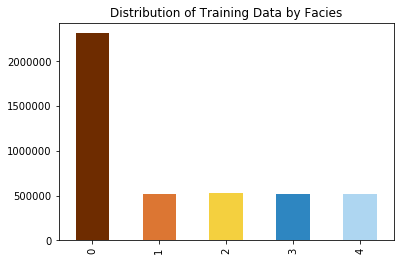

In [22]:
facies_colors = ['#6E2C00','#DC7633','#F4D03F',
                 '#2E86C1', '#AED6F1']

facies_counts = training_data['label'].value_counts().sort_index()
facies_counts.plot(kind='bar',color=facies_colors,title='Distribution of Training Data by Facies')

Very limited data to expect meaningfull correlation accross variables

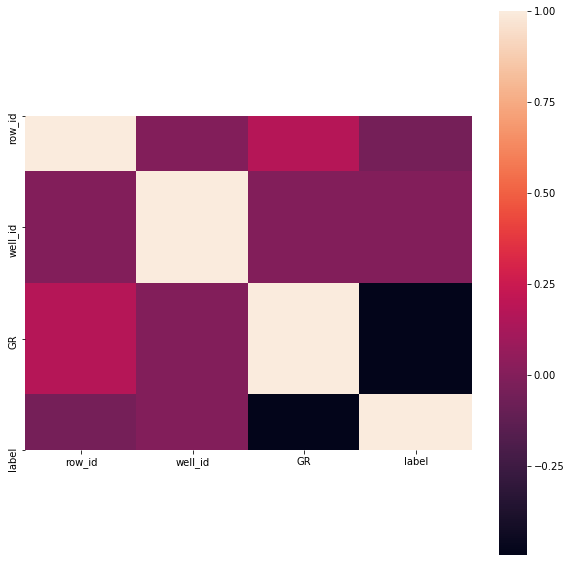

In [23]:
plt.figure(figsize=(10, 10))
sns.heatmap(training_data.corr(), vmax=1.0, square=True)

In [24]:
training_data.describe()

,row_id,well_id,GR,label
count,4.400000e+06,4.400000e+06,4.400000e+06,4.400000e+06
mean,5.495000e+02,1.999500e+03,1.092733e+02,1.184489e+00
std,3.175426e+02,1.154701e+03,3.424239e+01,1.465016e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.747500e+02,9.997500e+02,8.179222e+01,0.000000e+00
50%,5.495000e+02,1.999500e+03,1.203849e+02,0.000000e+00
75%,8.242500e+02,2.999250e+03,1.347291e+02,2.000000e+00
max,1.099000e+03,3.999000e+03,1.970614e+02,4.000000e+00


In [25]:
test_well = training_data[training_data['well_id'] == 0]

In [26]:
data = training_data[training_data['well_id'] != 0]

In [27]:
#      0=shale   1=mixed1  2=sst   3=mixed2 4=mixed3
ccc = ['#996633','blue','yellow','red','green']
cmap_facies = colors.ListedColormap(ccc[0:len(ccc)], 'indexed')

In [28]:
def smooth(x,window_len=11,window='hanning'):
    if x.ndim != 1:
        raise ValueError
    if x.size < window_len:
        raise ValueError
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError
    
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y  

In [29]:
def smooth_resample( y, newlen ):
    """ resample y to newlen, with B-spline smoothing """
    #n = len(y)
    downsampled =  scipy.signal.resample(y, newlen)
    #newgrid = np.linspace( 0, n - 1, newlen )
    #return map_coordinates( y, newgrid, mode="nearest", prefilter=False )
    return downsampled

In [30]:
def plot_well(well):
    cluster=np.repeat(np.expand_dims(test_well['label'].values,1), 100, 1)
    gr_values=well.GR.values.tolist()
    y=range(len(gr_values))

    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 12))
    ax[0].plot(gr_values, y)
    ax[0].invert_yaxis()
    ax[0].set_ylim(len(gr_values),0)
    ax[1].invert_yaxis()
    ax[1].set_ylim(len(gr_values),0)
    im=ax[1].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=4)

In [31]:
def plot_facies(well, figsize=(18, 8), repeat=100, save_name=None):
    cluster=np.repeat(np.expand_dims(well['label'].values,1), repeat, 1)
    rotated_img = ndimage.rotate(cluster, 90)

    if save_name:
        plt.rcParams["figure.figsize"] = figsize
        plt.imsave(f'{save_name}.png', rotated_img,cmap=cmap_facies,vmin=0,vmax=4)
        del rotated_img, cluster
        plt.close()
    else:
        im=plt.imshow(rotated_img, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=4)

In [32]:
def plot_signal(time, signal, figsize=(18, 4), save_name=None):
    plt.rcParams["figure.figsize"] = figsize
    plt.plot(time, signal, color='k')
    plt.xlim([time[0], time[-1]])
    plt.ylim([0, GR_MAX])
    if save_name:
        plt.axis('off')
        spec = plt.imshow
        plt.savefig(f'{save_name}.png', transparent = False, bbox_inches = 'tight', pad_inches = 0)
        del spec
        plt.close()

In [33]:
def delta_signal(signal):
    yarr=np.asarray(signal)
    yarr=np.diff(signal)
    yarr = np.insert(yarr, 0, signal[0], axis=0)
    assert len(yarr)==len(signal)
    return yarr

In [34]:
def y_trend(signal, N=15):
    y_mean=smooth(signal,window_len=N)
    #sample back out to originallength
    y=smooth_resample(y_mean, len(signal))
    y_delta_trend=delta_signal(y)
    return y_delta_trend

In [35]:
def rect(x,y,w,h,c):
    ax = plt.gca()
    polygon = plt.Rectangle((x,y),w,h,color=c)
    ax.add_patch(polygon)

def rainbow_fill(X,Y, trend_len, cmaps=['Blues_r','Reds_r']):
    '''Option for one or two cmpas per plot'''
    if len(cmaps)==1:
        cmap=plt.get_cmap(cmaps[0])
    else:
        cmap_1=plt.get_cmap(cmaps[0])
        cmap_2=plt.get_cmap(cmaps[1])
    plt.plot(X,Y,lw=0)  # Plot so the axes scale correctly, lw=linewidth
    plt.xlim([X[0], X[-1]])
    plt.ylim([0, GR_MAX])
    dx = X[1]-X[0]
    N  = float(len(X))
    
    ydeltas=y_trend(Y, trend_len)

    for n, (x,y, yd) in enumerate(zip(X,Y, ydeltas)):
        if len(cmaps)==1:
            color = cmap(y/GR_MAX)
        else:
            if yd>0:
                color = cmap_1(y/GR_MAX)
            else:
                color = cmap_2(y/GR_MAX)
        rect(x,0,dx,y,color)

In [36]:
def fill_signal(time, signal, figsize=(18, 4), save_name=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize)
    y2=signal*0
    assert len(time)==len(signal)
    ax.plot(time, signal, time, y2, color='black')
    ax.fill_between(time, signal, y2, where=signal >y2, facecolor='black')
    ax.set_xlim([time[0], time[-1]])
    if save_name:
        ax.axis('off')
        spec = plt.imshow
        plt.savefig(f'{save_name}.png', transparent = False, bbox_inches = 'tight', pad_inches = 0)
        del spec
        plt.close()

In [37]:
def rainbow_signal(time, signal, trend_len, figsize=(18, 4), cmaps=['jet'], save_name=None):
    plt.rcParams["figure.figsize"] = figsize
    rainbow_fill(time, signal, trend_len, cmaps)
    if save_name:
        plt.axis('off')
        spec = plt.imshow
        plt.savefig(f'{save_name}.png', transparent = False, bbox_inches = 'tight', pad_inches = 0)
        del spec
        plt.close()

In [38]:
def plot_wavelet(ax, time, signal, scales, waveletname = 'cmor', 
                 cmap = plt.cm.Spectral, title = '', ylabel = '', xlabel = ''):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    #print(f'levels: {contourlevels}, frequencies: {frequencies}, power: {power}' )
    #contour([X, Y,] Z, [levels], **kwargs)
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    return yticks, ylim, frequencies

In [39]:
def plot_well_wavelet(ax, time, signal, scales, waveletname = 'cmor', 
                 cmap = plt.cm.Spectral, title = '', ylabel = '', xlabel = '', plot_axes=True):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [1/32,1/16,1/8,1/4,1/2, 1, 2, 4, 8, 16, 32]
    contourlevels = np.log2(levels)
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    if plot_axes:
        ax.set_title(title, fontsize=20)
        ax.set_ylabel(ylabel, fontsize=18)
        ax.set_xlabel(xlabel, fontsize=18)
    
        yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
        ax.set_yticks(np.log2(yticks))
        ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    if waveletname=='morl' or waveletname=='shan':
        ax.set_ylim(7.0, 1.0)
    elif waveletname=='cgau1' or waveletname=='mexh' or waveletname=='cgau2':
        ax.set_ylim(8.0, 2.0)
    else:
        ax.set_ylim(8.0, 1.0)
    if not plot_axes:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [40]:
def plot_wavelet_tranform(x, y, figsize, title, waveletname = 'cmor', plot_axes=True, save_name=None, cmap= plt.cm.Spectral):
    scales = np.arange(1, 128)
    fig, ax = plt.subplots(figsize=(18, 4))
    plot_well_wavelet(ax, x, y, scales, title=title, waveletname = waveletname, plot_axes=plot_axes, cmap=cmap)
    if save_name:
        plt.axis('off')
        spec = plt.imshow
        plt.rcParams["figure.figsize"] = figsize
        plt.savefig(f'{save_name}', transparent = False, bbox_inches = 'tight', pad_inches = 0) 
        del spec
        plt.close()
    else:
        plt.show()

In [41]:
def plt_spec(data, figsize, save_name=None):
    NFFT =16
    noverlap=14
    pad_to=32
    ham_window = np.hamming(NFFT)
    detrend=None
    mode='psd'
    gr_dm=de_mean(data)
    plt.figure(figsize=(18,4))
    powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(gr_dm, window=ham_window, NFFT=NFFT, Fs=fs, noverlap=noverlap, scale=scale, pad_to=pad_to, detrend=detrend, mode=mode)
    plt.xticks([])
    plt.yticks([])
    if save_name:
        plt.axis('off')
        spec = plt.imshow
        plt.rcParams["figure.figsize"] = figsize
        plt.savefig(f'{save_name}.png', transparent = False, bbox_inches = 'tight', pad_inches = 0)
        del spec
        plt.close()

In [42]:
cluster=np.repeat(np.expand_dims(test_well['label'].values,1), 100, 1)

In [43]:
cluster.shape

(1100, 100)

In [44]:
cluster[:,0]

array([0, 0, 0, ..., 0, 0, 0])

In [45]:
cluster[:,5]

array([0, 0, 0, ..., 0, 0, 0])

In [46]:
def plot_well_hz(well, figsize=(12, 8)):
    cluster=np.repeat(np.expand_dims(well['label'].values,1), 100, 1)
    #cluster[:,0:10]=cluster[:,10:20]
    #cluster[:,89:99]=cluster[:,10:20]
    gr_values=well.GR.values.tolist()
    x=range(len(gr_values))

    f, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    ax[0].plot(x, gr_values)
    ax[0].set_xlim(0, len(gr_values))
    ax[1].set_xlim(0, len(gr_values))
    rotated_img = ndimage.rotate(cluster, 90)
    im=ax[1].imshow(rotated_img, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=4)

In [47]:
gr_values=test_well.GR.values.tolist()
time=range(len(gr_values))
plot_signal(time, gr_values, figsize=(18, 4),save_name='test')

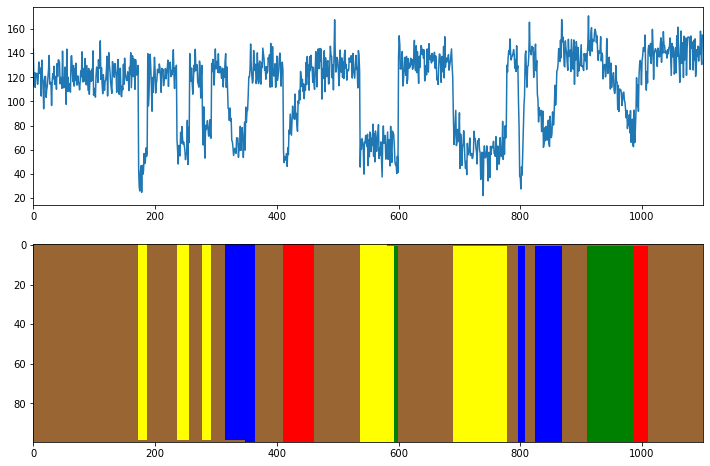

In [48]:
plot_well_hz(test_well)

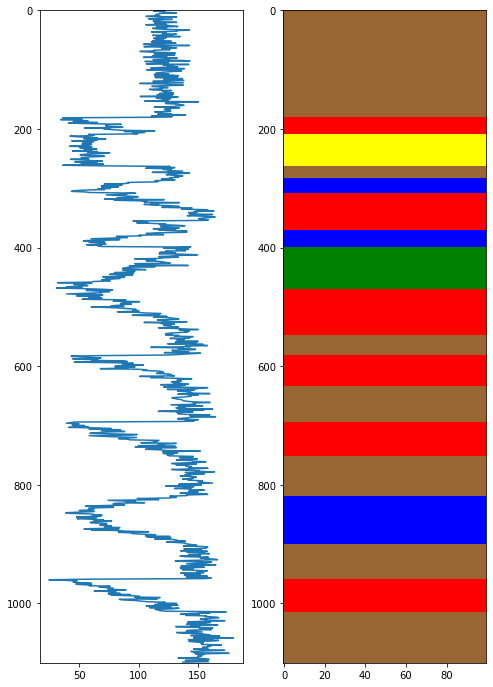

In [49]:
test_well = training_data[training_data['well_id'] == 1]
plot_well(test_well)

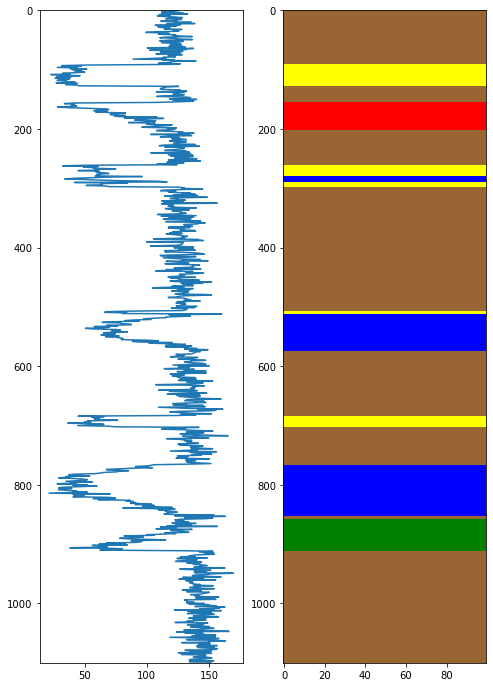

In [50]:
test_well = training_data[training_data['well_id'] == 2]
plot_well(test_well)

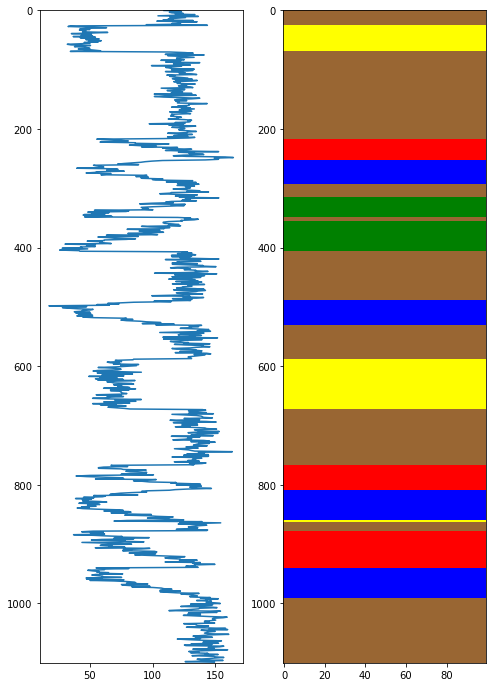

In [51]:
test_well = training_data[training_data['well_id'] == 3]
plot_well(test_well)

In [52]:
len(test_well.GR.values)

1100

## Spectrograms

In [53]:
def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

In [54]:
def de_mean(signal):
    # removing the mean of the signal
    mean_removed = np.ones_like(signal)*np.mean(signal)
    signal_demean = signal - mean_removed
    return signal_demean

In [55]:
dt = 0.5
fs = int(1.0 / dt)
# The number of data points used in each block for the FFT ie the length of the windowing segments. Use power of 2
NFFT =128
#must be less than n
noverlap=8
#scale linear or dB
scale='dB'
ham_window = np.hamming(NFFT)

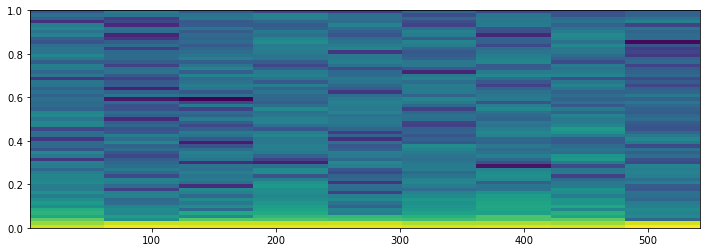

In [56]:
plt.figure(figsize=(12,4))
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(test_well.GR.values, window=ham_window, NFFT=NFFT, Fs=fs, noverlap=noverlap, scale=scale)

In [57]:
NFFT =8
noverlap=7
pad_to=64
ham_window = np.hamming(NFFT)

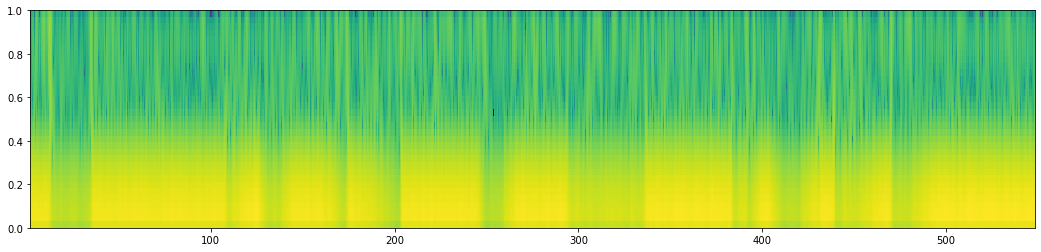

In [58]:
plt.figure(figsize=(18,4))
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(test_well.GR.values, window=ham_window, NFFT=NFFT, Fs=fs, noverlap=noverlap, scale=scale, pad_to=pad_to)

In [59]:
NFFT =16
noverlap=14
pad_to=64
ham_window = np.hamming(NFFT)
#detrend='linear', 'mean', None
detrend=None
#mode : {'default', 'psd', 'magnitude', 'angle', 'phase'}
mode='psd'

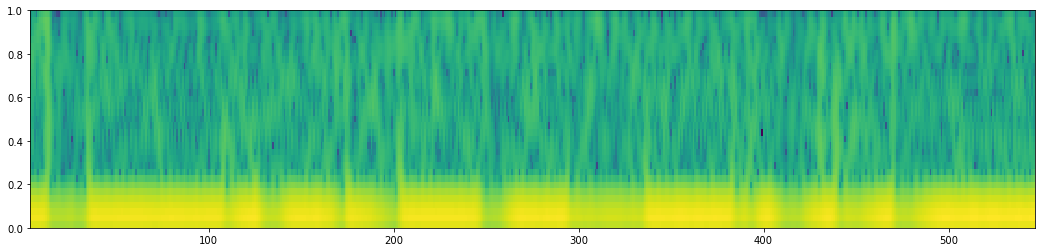

In [60]:
plt.figure(figsize=(18,4))
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(test_well.GR.values, window=ham_window, NFFT=NFFT, Fs=fs, noverlap=noverlap, scale=scale, pad_to=pad_to, detrend=detrend, mode=mode)

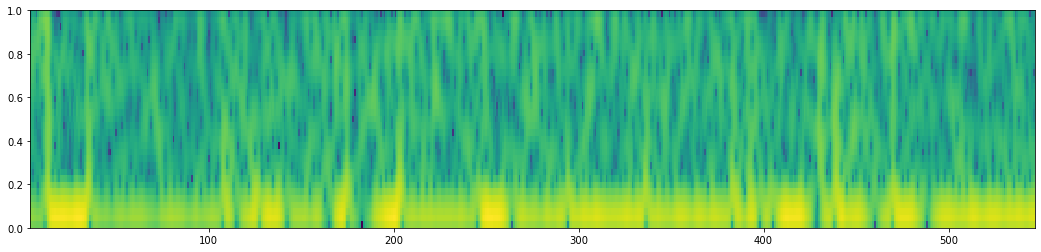

In [61]:
NFFT =16
noverlap=14
pad_to=64
ham_window = np.hamming(NFFT)
detrend=None
mode='psd'
gr_dm=de_mean(test_well.GR.values)
plt.figure(figsize=(18,4))
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(gr_dm, window=ham_window, NFFT=NFFT, Fs=fs, noverlap=noverlap, scale=scale, pad_to=pad_to, detrend=detrend, mode=mode)

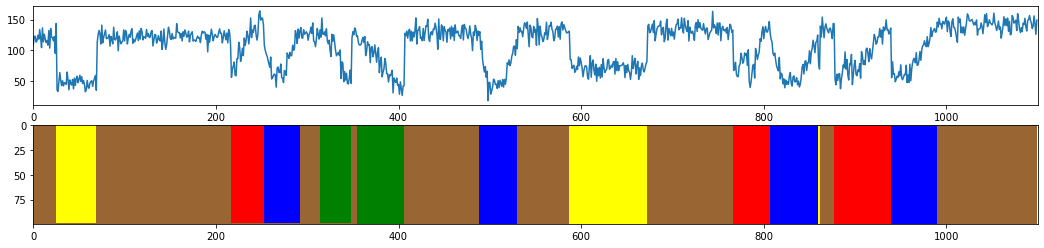

In [62]:
plot_well_hz(test_well, figsize=(18, 4))

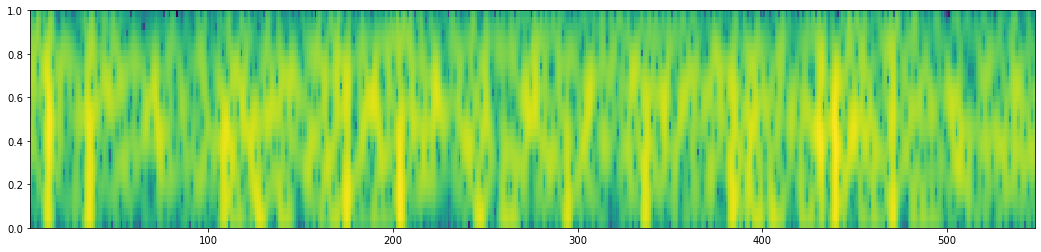

In [63]:
smth_y=smooth(gr_dm, window_len = 3)
gr_dm_grad=np.gradient(smth_y)

plt.figure(figsize=(18,4))
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(gr_dm_grad, window=ham_window, NFFT=NFFT, Fs=fs, noverlap=noverlap, scale=scale, pad_to=pad_to, detrend=detrend, mode=mode)

In [64]:
#see https://stackoverflow.com/questions/26253947/logarithmic-colormap-in-matplotlib
class ReNormColormapAdaptor(mpl.colors.Colormap):
    """ Colormap adaptor that uses another Normalize instance
    for the colormap than applied to the mappable. """
    def __init__(self,base,cmap_norm,orig_norm=None):
        if orig_norm is None:
            if isinstance(base,mpl.cm.ScalarMappable):
                orig_norm = base.norm
                base = base.cmap
            else:
                orig_norm = mpl.colors.Normalize(0,1)
        self._base = base
        if (
            isinstance(cmap_norm,type(mpl.colors.Normalize))
            and issubclass(cmap_norm,mpl.colors.Normalize)
        ):
            # a class was provided instead of an instance. create an instance
            # with the same limits.
            cmap_norm = cmap_norm(orig_norm.vmin,orig_norm.vmax)
        self._cmap_norm = cmap_norm
        self._orig_norm = orig_norm

    def __call__(self, X, **kwargs):
        """ Re-normalise the values before applying the colormap. """
        return self._base(self._cmap_norm(self._orig_norm.inverse(X)),**kwargs)

    def __getattr__(self,attr):
        """ Any other attribute, we simply dispatch to the underlying cmap. """
        return getattr(self._base,attr)

In [65]:
cmap = ReNormColormapAdaptor(mpl.cm.nipy_spectral,mpl.colors.LogNorm(0.1,2.5))

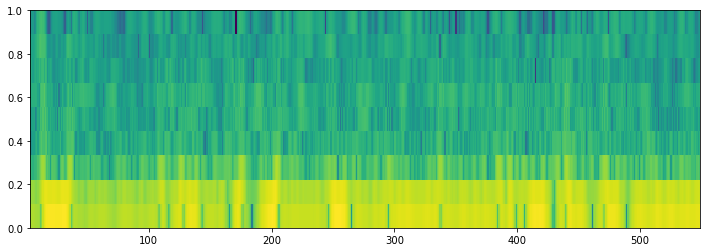

In [66]:


NFFT =16
noverlap=14
dt = 0.5
fs = int(1.0 / dt)
data=test_well.GR.values
gr_dm=de_mean(data)
gr_rm=smooth(gr_dm,window_len=5)
gr_sm = smooth(gr_dm, window_len=5, window='flat')
plt.figure(figsize=(12,4))

powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(gr_sm, window=ham_window, NFFT=NFFT, Fs=fs, noverlap=noverlap, scale=scale, cmap='viridis')

In [67]:
### Example 1 En Nino

#see http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

In [68]:
dataset = "https://raw.githubusercontent.com/taspinar/siml/master/datasets/sst_nino3.dat.txt"
df_nino = pd.read_table(dataset)
N = df_nino.shape[0]
#t0=1871
t0=0
dt=0.25
#dt=1.0
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()

In [69]:
len(signal)

503

In [70]:
# First lets load the el-Nino dataset, and plot it together with its time-average
def plot_signal_plus_average(ax, time, signal, average_over = 5):
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Amplitude', fontsize=16)
    ax.set_title('Signal + Time Average', fontsize=16)
    ax.legend(loc='upper right')

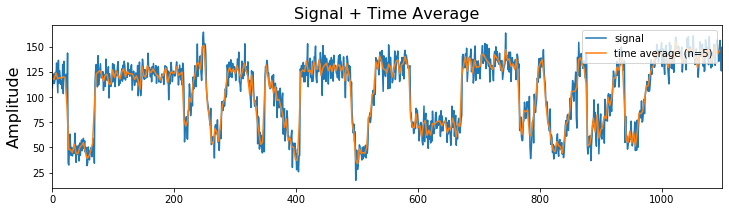

In [71]:
gr_time=range(len(test_well.GR.values))
gr_signal=((test_well.GR.values))

fig, ax = plt.subplots(figsize=(12,3))
plot_signal_plus_average(ax, gr_time, gr_signal, average_over = 3)
plt.show()

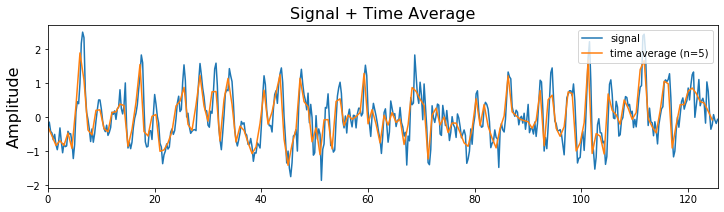

In [72]:
fig, ax = plt.subplots(figsize=(12,3))
plot_signal_plus_average(ax, time, signal, average_over = 3)
plt.show()

In [73]:
def get_fft_values(y_values, T, N):
    xf = np.linspace(0.0, N*T, N)
    yf_ = fft(y_values)
    yf = 2.0/N * np.abs(yf_[0:N/2])
    return xf, yf

def get_fft_values2(y_values, T, N):
    N2 = 2 ** (int(np.log2(N)) + 1) # round up to next highest power of 2
    xf = np.linspace(0.0, 1.0/(2.0*T), N2//2)
    yf_ = fft(y_values)
    yf = 2.0/N2 * np.abs(yf_[0:N2//2])
    return xf, yf

def plot_fft_plus_power(ax, time, signal, plot_direction='horizontal', yticks=None, ylim=None):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values2(signal, dt, N)
    fft_power = variance * abs(fft_values) ** 2
    if plot_direction == 'horizontal':
        ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
        ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    elif plot_direction == 'vertical':
        scales = 1./f_values
        scales_log = np.log2(scales)
        ax.plot(fft_values, scales_log, 'r-', label='Fourier Transform')
        ax.plot(fft_power, scales_log, 'k--', linewidth=1, label='FFT Power Spectrum')
        ax.set_yticks(np.log2(yticks))
        ax.set_yticklabels(yticks)
        ax.invert_yaxis()
        ax.set_ylim(ylim[0], -1)
    ax.legend()

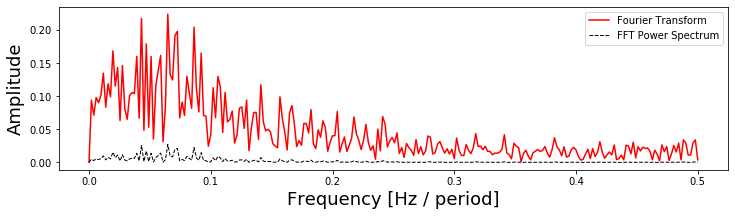

In [74]:
signal_demean = de_mean(signal)
time=range(len(signal_demean))
fig, ax = plt.subplots(figsize=(12,3))
ax.set_xlabel('Frequency [Hz / period]', fontsize=18)
ax.set_ylabel('Amplitude', fontsize=18)
plot_fft_plus_power(ax, time, signal_demean)
plt.show()

/home/walle/miniconda3/envs/applied_dl_tf/lib/python3.6/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


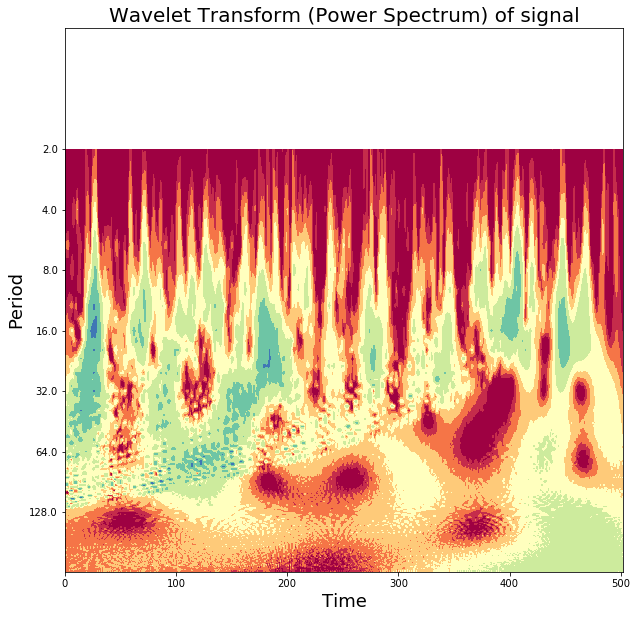

In [75]:
scales = np.arange(1, 128)
title = 'Wavelet Transform (Power Spectrum) of signal'
ylabel = 'Period'
xlabel = 'Time'

fig, ax = plt.subplots(figsize=(10, 10))
yticks, ylim, frequencies=plot_wavelet(ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)
plt.show()

<BarContainer object of 127 artists>

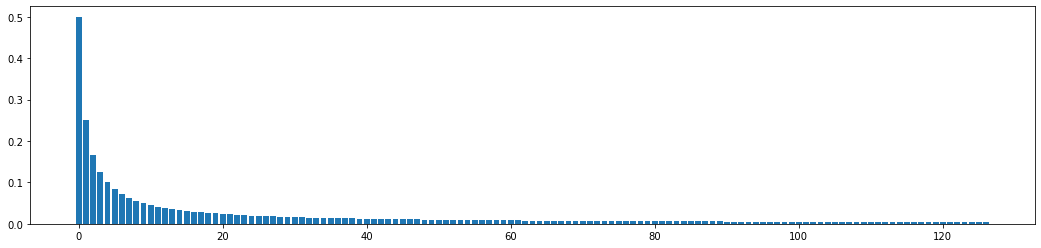

In [76]:
plt.bar(range(len(frequencies)),frequencies)

Apply to GR logs

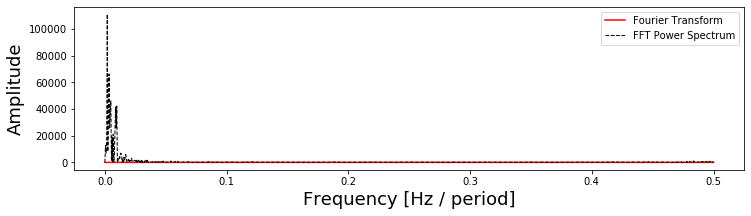

In [77]:
gr_time=range(len(test_well.GR.values))
gr_signal=((test_well.GR.values))

# removing the mean of the signal
mean_removed = np.ones_like(gr_signal)*np.mean(gr_signal)
gr_demean = gr_signal - mean_removed

fig, ax = plt.subplots(figsize=(12,3))
ax.set_xlabel('Frequency [Hz / period]', fontsize=18)
ax.set_ylabel('Amplitude', fontsize=18)
plot_fft_plus_power(ax, gr_time, gr_demean)
plt.show()

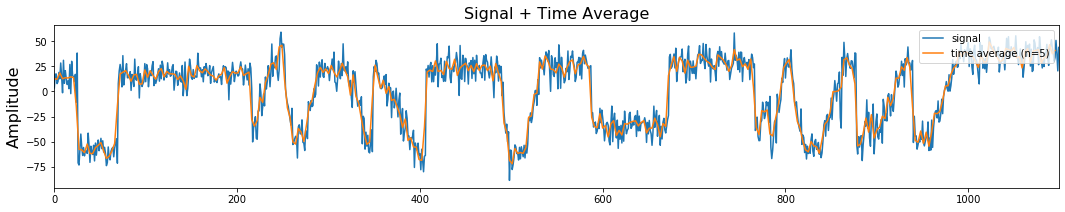

In [78]:
gr_demean=de_mean(test_well.GR.values)
gr_time=range(len(gr_demean))

fig, ax = plt.subplots(figsize=(18,3))
plot_signal_plus_average(ax, gr_time, gr_demean, average_over = 3)
plt.show()

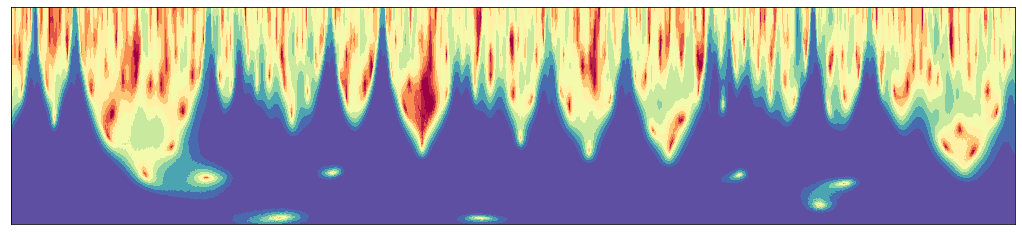

In [79]:
plot_wavelet_tranform(gr_time, gr_demean/10, figsize=(18,4), title='well', waveletname = 'cgau2', plot_axes=False)

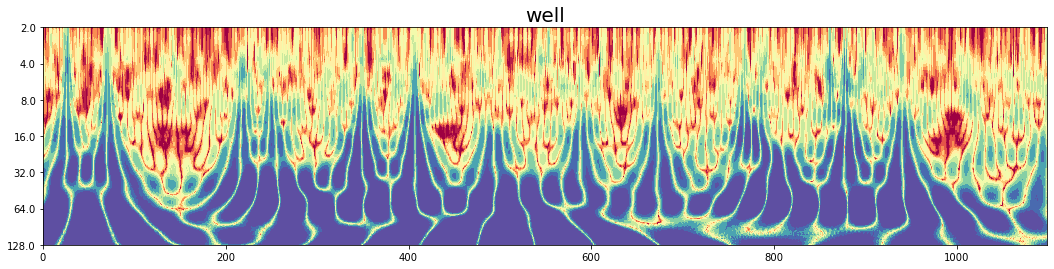

In [80]:
plot_wavelet_tranform(gr_time, gr_demean/10, figsize=(18,4), title='well', waveletname = 'morl')

/home/walle/miniconda3/envs/applied_dl_tf/lib/python3.6/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


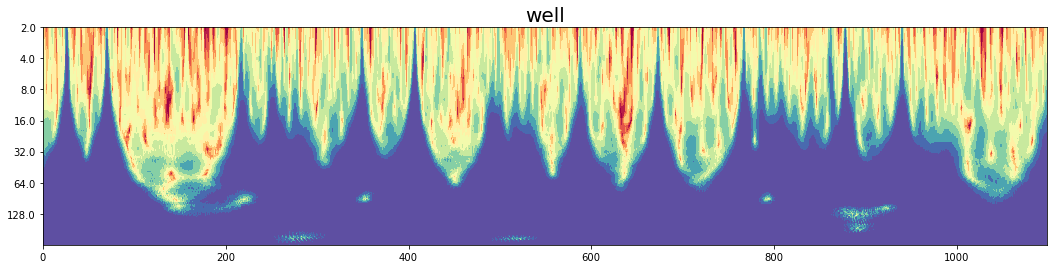

In [81]:
plot_wavelet_tranform(gr_time, gr_demean/10, figsize=(18,4), title='well', waveletname = 'fbsp')

/home/walle/miniconda3/envs/applied_dl_tf/lib/python3.6/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


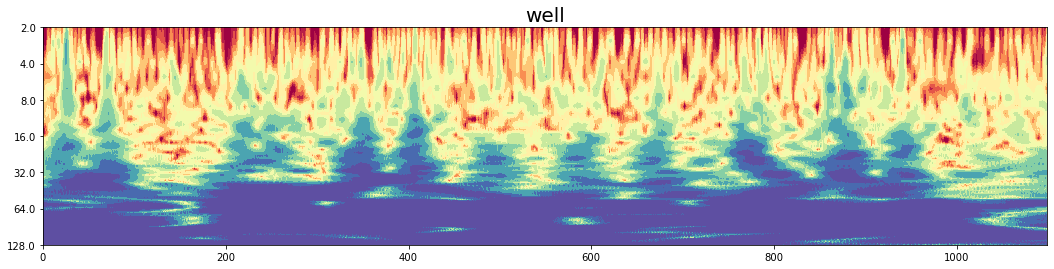

In [82]:
plot_wavelet_tranform(gr_time, gr_demean/10, figsize=(18,4), title='well', waveletname = 'shan')

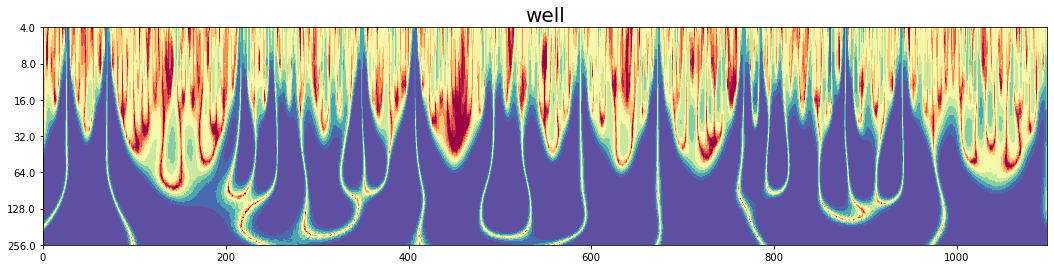

In [83]:
plot_wavelet_tranform(gr_time, gr_demean/10, figsize=(18,4), title='well', waveletname = 'mexh')

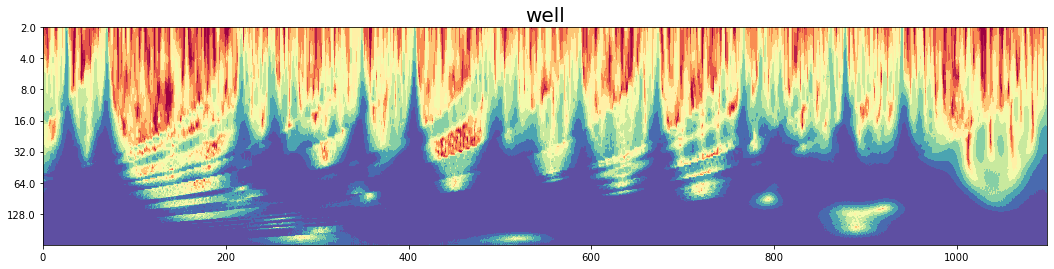

In [84]:
plot_wavelet_tranform(gr_time, gr_demean/10, figsize=(18,4), title='well', waveletname = 'cmor')

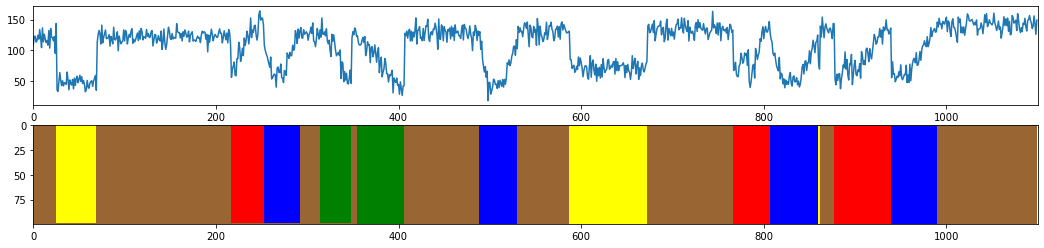

In [85]:
plot_well_hz(test_well,figsize=(18, 4))

<BarContainer object of 127 artists>

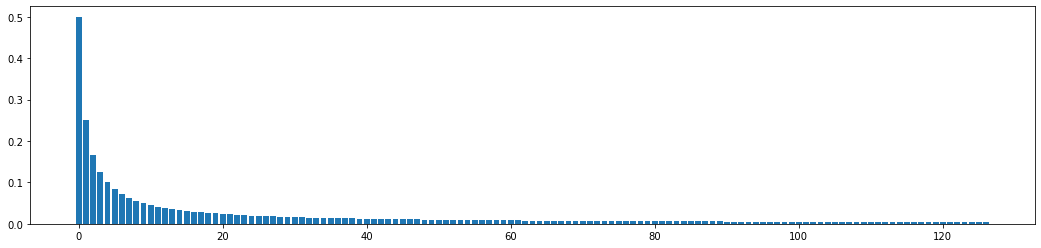

In [86]:
plt.bar(range(len(frequencies)),frequencies)

In [87]:
test_well_1 = training_data[training_data['well_id'] == 1]
gr_demean=de_mean(test_well_1.GR.values)
gr_time=range(len(gr_demean))

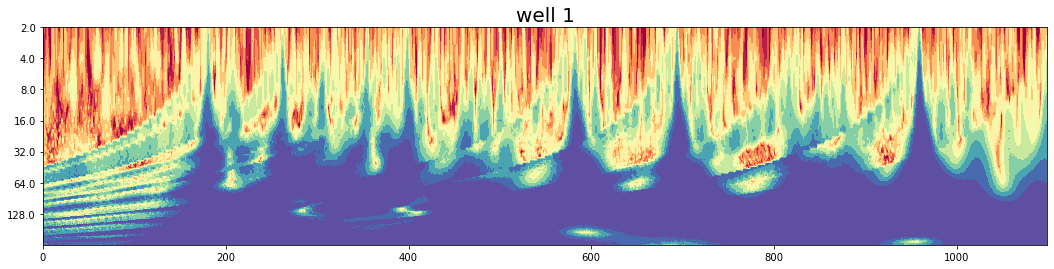

In [88]:
plot_wavelet_tranform(gr_time, gr_demean/10, figsize=(18, 4), title='well 1')

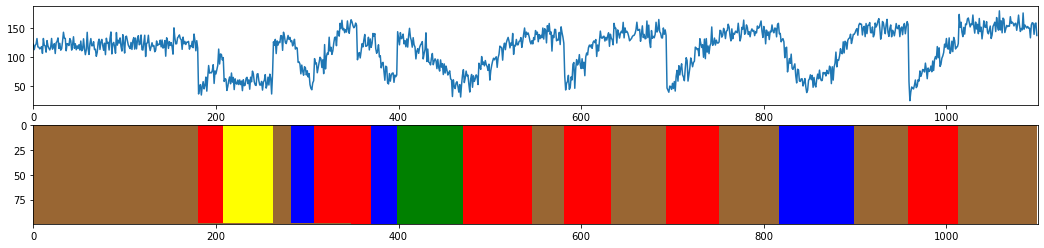

In [89]:
plot_well_hz(test_well_1,figsize=(18, 4))

In [90]:
test_well_10 = training_data[training_data['well_id'] == 10]
gr_demean=de_mean(test_well_10.GR.values)
gr_time=range(len(gr_demean))

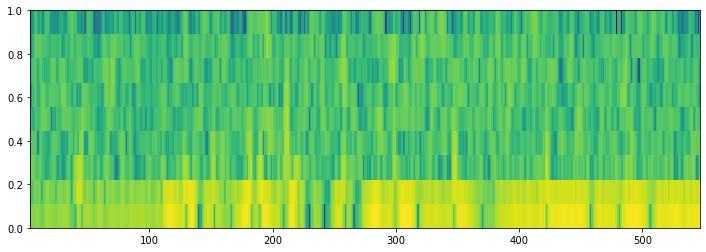

In [91]:
NFFT =16
noverlap=14
plt.figure(figsize=(12,4))
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(gr_demean, window=ham_window, NFFT=NFFT, Fs=fs, noverlap=noverlap, scale=scale, cmap='viridis')

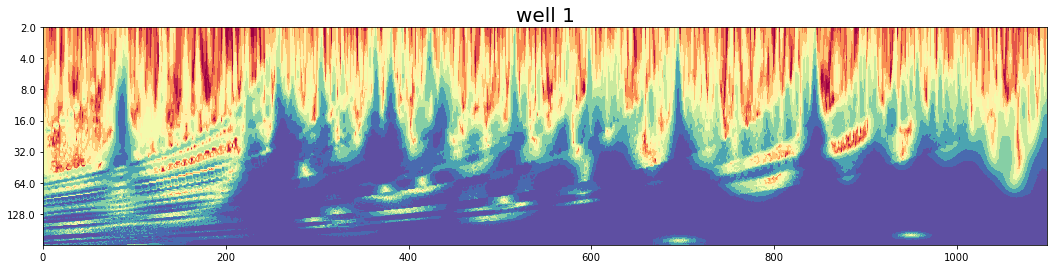

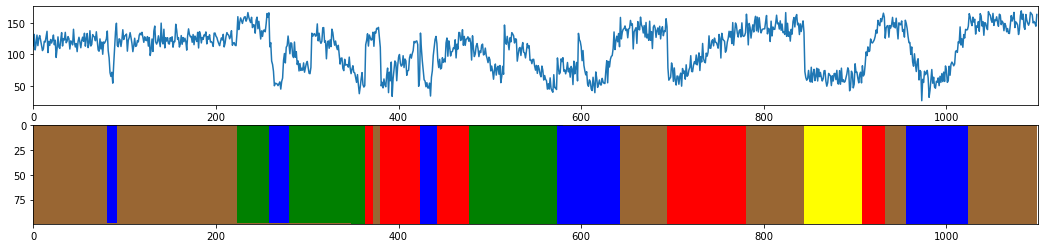

In [92]:
plot_wavelet_tranform(gr_time, gr_demean/10, figsize=(18, 4), title='well 1')

plot_well_hz(test_well_10,figsize=(18, 4))

### plot the derivative

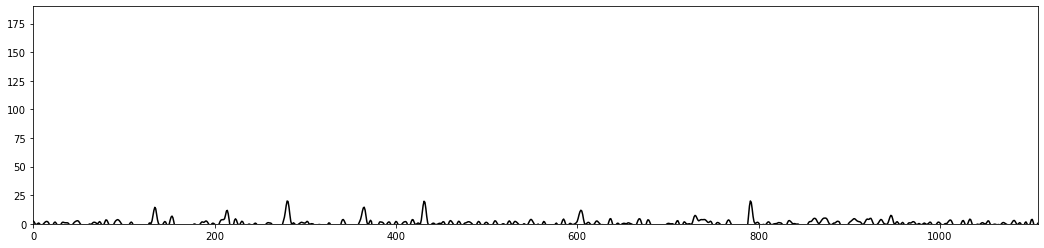

In [93]:
well = training_data[training_data['well_id'] == 5]
gr_data=well.GR.values

smth_y=smooth(gr_data, window_len = 10)
gr_dm_grad=np.gradient(smth_y)
gr_dm_grad.shape
plot_signal(range(len(gr_dm_grad)), gr_dm_grad, figsize=(18, 4))

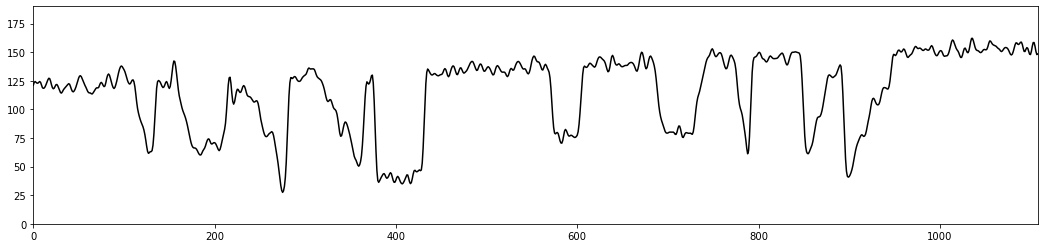

In [94]:
smth_y=smooth(gr_data, window_len = 10)
plot_signal(range(len(smth_y)), smth_y, figsize=(18, 4))

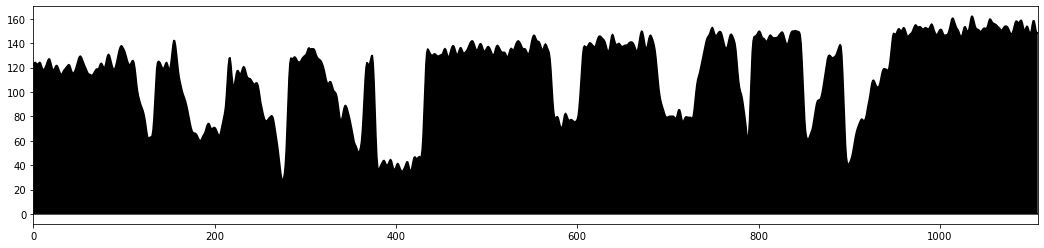

In [95]:
fill_signal(range(len(smth_y)), smth_y, figsize=(18, 4))

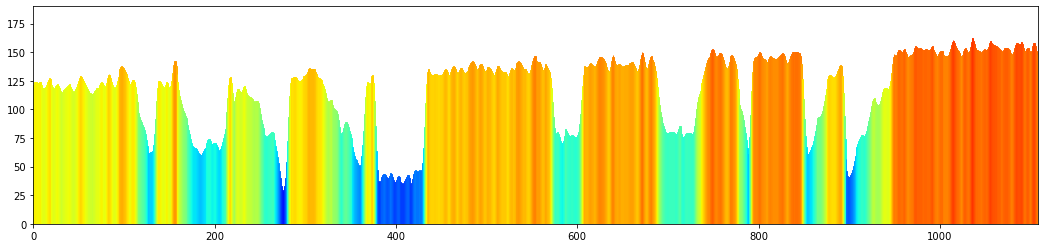

In [96]:
rainbow_signal(range(len(smth_y)), smth_y, trend_len=3, figsize=(18, 4), cmaps=['jet'])

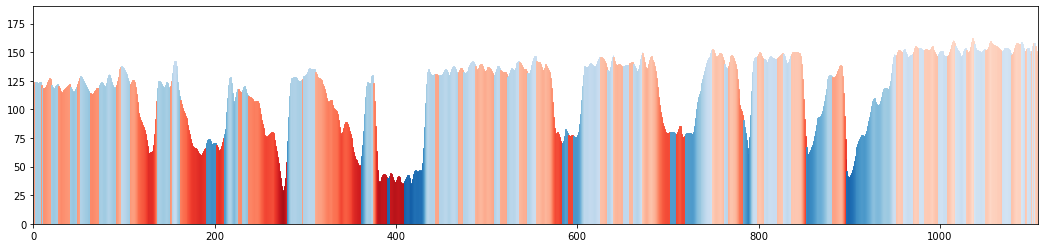

In [97]:
rainbow_signal(range(len(smth_y)), smth_y, trend_len=20, figsize=(18, 4), cmaps=['Blues_r','Reds_r'])

Having two colour maps - one for upwards fining, one for upwards coarsening looks to allow better representation than just using color based og GR absolute value.

A trend smoother is applied - ie delta between GR values is calculated on a smoothed version of the GR log to capture a more general log trend.

In [98]:
pid = os.getpid()
py = psutil.Process(pid)
memoryUse = py.memory_info()[0]/2.**30
print('memory use:', memoryUse)

memory use: 0.4539680480957031


In [99]:
@profile
def plot_wells_basic(well_ids):
    '''Note use of epsolin sclars to the DPI to exactly match the image size of the facies image 1100x275
    Couldn't work out how to get mpl to imsave to a specific size'''
    figsize=((IMG_HEIGHT*4)/51.905454545, IMG_HEIGHT/50.487272727)
    for i in well_ids:
        if (i % 100)==0:
            memoryUse = py.memory_info()[0] / 2. ** 30
            print(f'processing well {i}, memoryUse: {memoryUse}')
        well = training_data[training_data['well_id'] == i]
        gr_data=well.GR.values
        smth_y=smooth(gr_data, window_len = 5)
        time=range(len(gr_data))
        assert len(gr_data)==1100
        plot_facies(well, figsize, repeat=int(len(gr_data)/4), save_name=f'{train_images}/well_{i}_facies')
        plot_signal(range(len(gr_data)), gr_data, figsize=figsize, save_name=f'{train_images}/well_{i}_GR_line')
        rainbow_signal(time, gr_data, trend_len=20, figsize=figsize, cmaps=['Blues_r','Reds_r'], save_name=f'{train_images}/well_{i}_GR')
        gc.collect()

In [100]:
well_ids=training_data.well_id.unique().tolist()
plot_wells_basic(well_ids[3000:])

ERROR: Could not find file <ipython-input-99-3a166e2d7ae5>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
processing well 3000, memoryUse: 0.45916748046875
processing well 3100, memoryUse: 2.4562034606933594
processing well 3200, memoryUse: 4.507289886474609
processing well 3300, memoryUse: 6.558162689208984
processing well 3400, memoryUse: 8.609683990478516
processing well 3500, memoryUse: 10.660358428955078
processing well 3600, memoryUse: 12.711071014404297
processing well 3700, memoryUse: 14.763187408447266
processing well 3800, memoryUse: 16.813678741455078
processing well 3900, memoryUse: 18.864540100097656


In [101]:
def plot_wells_extended(well_ids):
    '''Note use of epsolin sclars to the DPI to exactly match the image size of the facies image 1100x275
    Couldn't work out how to get mpl to imsave to a specific size'''
    figsize=((IMG_HEIGHT*4)/51.905454545, IMG_HEIGHT/50.487272727)
    for i in well_ids:
        if (i % 100)==0:
            print(f'processing well {i}')
            memoryUse = py.memory_info()[0] / 2. ** 30
            print(f'id: {id}, memory use: {memoryUse}, mem: {show_mem_usage()}') 
        well = training_data[training_data['well_id'] == i]
        gr_data=well.GR.values
        smth_y=smooth(gr_data, window_len = 5)
        time=range(len(gr_data))
        assert len(gr_data)==1100
        plot_facies(well, figsize, repeat=int(len(gr_data)/4), save_name=f'{train_images}/well_{i}_facies')
        plot_signal(range(len(smth_y)), smth_y, figsize, save_name=f'{train_images}/well_{i}_GR_line_smth_5')
        rainbow_signal(range(len(smth_y)), smth_y, trend_len=20, figsize=figsize, cmaps=['Blues_r','Reds_r'], save_name=f'{train_images}/well_{i}_GR_smth_5')
        plt_spec(gr_values, figsize, save_name=f'{train_images}/well_{i}_spec')
        gr_dm=de_mean(gr_data)
        plot_wavelet_tranform(gr_time, gr_dm/10, figsize, title='', waveletname = 'cmor', plot_axes=False, save_name=f'{train_images}/well_{i}_cmor_wvlt', cmap= plt.cm.Spectral)
        plot_wavelet_tranform(gr_time, gr_dm/10, figsize, title='', waveletname = 'cgau2', plot_axes=False, save_name=f'{train_images}/well_{i}_cgau2_wvlt', cmap= plt.cm.Spectral)
        plot_wavelet_tranform(gr_time, gr_dm/10, figsize, title='', waveletname = 'shan', plot_axes=False, save_name=f'{train_images}/well_{i}_shan_wvlt', cmap= plt.cm.Spectral)
        gc.collect()

In [102]:
#plot_wells_extended(well_ids)